In [ ]:
#Import of relevant packages
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import geopandas as gpd
from shapely.geometry import MultiPolygon
from tqdm import tqdm
import gdown
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode
init_notebook_mode(connected= True)
import plotly.express as px
import time
import statsmodels.formula.api as sm
import statsmodels

In [ ]:
#Import of sklearn functions
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix


In [ ]:
base = pd.read_csv("INSEE_DATA_TREATED.csv", delimiter=",")

**/!\ WARNING : This notebook should only be run after the import and formatting notebook**

# Analysis of the number of hours worked

The question we want to explore in this section is the relationship between sex and labor market participation, with a focus on the intensive margin. That women participate less often to the labor market is a widely known fact that has existed for many years, though the trend of women participating has been increasing over the last century. Even conditional on participating, women generally tend to participate less on the intensive margin, e.g. resorting more frequently than men to part-time contracts.

Using our database representative of all salaried workers of France in 2021, we study the number of hours spent working by men and women conditionnally on being employed during the whole year. More specifically, we focus on two outcomes:

- the **total number of hours worked**; and
- **extra-hours**, i.e. a dummy variable indicating whether the employee has worked more than the regular number of hours (52 weeks * 35 hours = 1820 hours).

## Descriptive statistics on working hours

We first begin by doing some descriptive statistics on our outcome variable (snumber of hours worked, frequency of extra-hours) and to relate them to the duration of the contract.

In [ ]:
base[["NBHEUR", "DUREE"]].describe()

,NBHEUR,DUREE
count,2.315888e+06,2.315888e+06
mean,1.376363e+03,2.949483e+02
std,5.692307e+02,1.011707e+02
min,0.000000e+00,1.000000e+00
25%,9.150000e+02,2.400000e+02
50%,1.644000e+03,3.600000e+02
75%,1.820000e+03,3.600000e+02
max,2.500000e+03,3.600000e+02


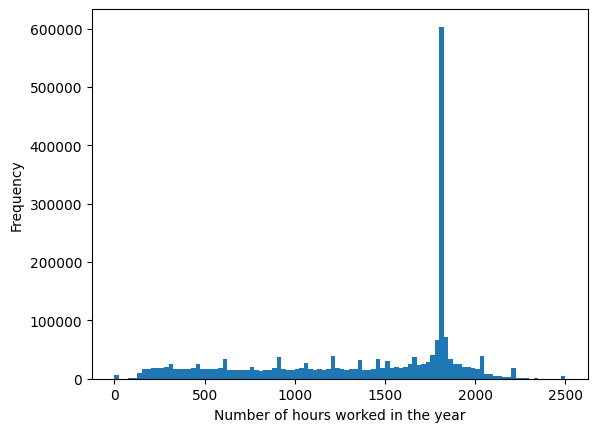

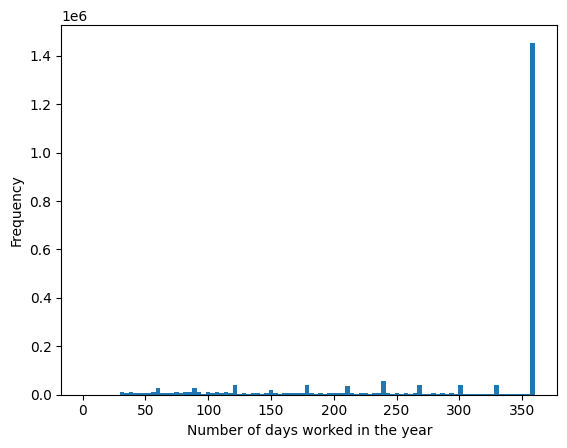

In [ ]:
# Plotting the number of hours worked in the year
fig, ax = plt.subplots()
ax.hist(base['NBHEUR'], bins=100, cumulative=False, log=False)
ax.set_xlabel('Number of hours worked in the year')
ax.set_ylabel('Frequency')
plt.show()

# Plotting the number of days worked in the year
fig, ax = plt.subplots()
ax.hist(base['DUREE'], bins=100, cumulative=False, log=False)
ax.set_xlabel('Number of days worked in the year')
ax.set_ylabel('Frequency')
plt.show()

As both graphs above show, the number of hours worked as well as the number of days worked exhibit strong patterns. Regarding the number of days, we see higher frequencies for each multiple of 30 days, indicating that employees employed for less than a full year typically had contracts whose duration was calculated in full months. For the number of hours, a large mode of the data is around 1820 hours, indicating a full-time 35-hours/week typical contracts. We also observe higher frequencies around that value, both below and above, indicating that reported hours can vary slughtly around that value. The same pattern as for the number of days is also exhibited in the data, as we can see higher frequencies corresponding to full-time contracts for a given number of full months spent working. The right-hand tail of the graph exhibit a significant share of the workers whor are doin extra-hours, justifying our focus on that question.

To confirm the strength of the relationship between the duration of the contract and the number o working hours, we estimate the small descriptive model:

$Nb\_hours = \alpha_0 + \beta \times Nb\_days + \epsilon$

In [ ]:
# Correlation between the duration of the contract and the number of hours worked
model = sm.ols('NBHEUR ~ DUREE', data=base).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 NBHEUR   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                 5.510e+06
Date:                Mon, 31 Mar 2025   Prob (F-statistic):               0.00
Time:                        19:15:54   Log-Likelihood:            -1.6569e+07
No. Observations:             2315888   AIC:                         3.314e+07
Df Residuals:                 2315886   BIC:                         3.314e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.0958      0.627    -25.664      0.0

The model is almost perfectly linear, the intercept being close to 0, even if significantly different from it. For a full-time job, we would have expected the value of the coefficient $\beta$ to be $\frac{\text{35 hours / week}}{\text{7 days / week}} = \text{5 hours a day}$. The estimated value of 4.72 reflects that there are more employees doing a part-time job than there are working extra-hours.

Lastly, we look at the share of workers doing extra-hours in 2021 among those that are emplyed for the full year. This restriction creates a small bias in the types of contracts that we study, which might slightly alter the quality of our results, but we believe that the study of extra-hours in short-term contracts is a subject of its own which should be studied on the full dataset to get higher identification power and heterogeneities.

In [ ]:
# Creating dummy variables indicating that the worker worked more than 35h a week
base["top_extra_hour_tot"] = (base["NBHEUR"] > 1820).astype(int)
base["top_extra_hour_tot_sup35"] = (base["NBHEUR"] > 1855).astype(int)
base[base["DUREE"] == 360].groupby(["top_extra_hour_tot", "top_extra_hour_tot_sup35"]).size()


top_extra_hour_tot  top_extra_hour_tot_sup35
0                   0                           1092029
1                   0                            112317
                    1                            237746
dtype: int64

As we can see, the number of workers doing extra-hours is significant (roughly 350 000 workers in our sample, or 24%), although it does not represent a very large share of the whole population. Additionnally, among those doing extra-hours, more than two thirds do strictly more than 35 extra hours, which indicate that the phenomenon is quite sizeable for them.

## Doing LASSO regressions on the total number of hours worked

In [ ]:
#Import of relevant packages
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix


In [ ]:
# Creation of variables
TREFF_to_categ = {0 : "00",
                  1 : "1-9",
                  2 : "10-19",
                  3 : "20-49",
                  4 : "50-99",
                  5 : "100-249",
                  6 : "250+"
}
base['TREFF_N'] = base['TREFF'].replace(TREFF_to_categ)
base['AGE_SQ'] = base['AGE']**2
base["CS_cat"] = base["CS"].astype("string")
base["top_extra_hour_tot"] = (base["NBHEUR"] > 1820).astype(int)

In [ ]:
base["NBHEUR_STD"] = (base["NBHEUR"] - np.mean(base["NBHEUR"]))/ np.std(base["NBHEUR"])
base[["NBHEUR", "NBHEUR_STD"]]

,NBHEUR,NBHEUR_STD
0,1821.0,0.781119
1,1572.0,0.343686
2,1825.0,0.788146
3,364.0,-1.778477
4,1764.0,0.680984
...,...,...
2403770,NaN,NaN
2403771,NaN,NaN
2403772,NaN,NaN
2403773,NaN,NaN


The first outcome that we study is the total number of hours worked. For that analysis as well as for the next one, we only focus on contracts that lasted for the whole year, so results on short-term contracts such as CDD should be interpreted with caution.

Our question is to understand whether the sex of the employee plays a role, and if so by how much, once we have controlled for things such as the type of contract, the activity sector, the Socioprofessional category, the size of the firm and the age of the patient. We also have in the data a variables indicating whether the worker has a part-time contract or not, but we do not include this variables as its construction could be too correlated to our outcome variable.

Here we try the following LASSO model:
$\text{Nb_Hours} = \alpha_0 + \beta_1 \times \text{SPC} + \beta_2 \times \text{Type_Job} + \beta_3 \times \text{Type_Contract} + \beta_4 \times \text{Activity Sector} + \beta_5 \times \text{Département} + \beta_6 \times \text{Business_Sector} + \beta_7 \times \text{Age} + \beta_8 \times \text{Age}^2 + \beta_9 \times \text{Sex} + \epsilon$

We are thus minimizing the following program:
$\hat{\beta} = \arg\min_{\beta} \left( \sum_{i=1}^{n} \left( y_i - \mathbf{x}_i^\top \beta \right)^2 + \lambda \sum_{j=1}^{9} |\beta_j| \right)$,
where $\beta$ is the vector of coefficients ($\beta_1$,...,$\beta_9$)

The model is estimated by cross-validation on 80% of the data (training_set), trying 5 different values of the regularizing pparameter $\lambda$ : 0.001, 0.01, 0.1, 1, 10, and cross-validating 3 times within the training set for each of these lambda. We then extracts the coefficients selected with the optimal lambda determined above and interpret them. The quallity of the model relies on predictions done on the 20% of the observations that are kept aside for the testing (test_set)

In [ ]:
## This cell conducts cross-validation on the linear LASSO model on the number of working hours, using standardized explanatory variables.


# Select relevant variables and keep only observations with all informatiosn
all_columns = ["TYP_EMPLOI", "DEPT", "CONT_TRAV", "CS_N", "A38_N", "TREFF_N", "SEXE", "AGE_SQ", "AGE"]
cleaned_base = base[base["DUREE"] == 360][all_columns + ["NBHEUR_STD"]].dropna()
X = cleaned_base[all_columns]
y = cleaned_base['NBHEUR_STD']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20250401)

# Selects and transforms the relevant variables
categorical_columns = ["TYP_EMPLOI", "DEPT", "CONT_TRAV", "CS_N", "A38_N", "TREFF_N"]
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
numerical_columns = ["SEXE", "AGE_SQ", "AGE"]

preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),

    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

# Doing the lasso regressiion
alphas = np.logspace(np.log10(0.001), np.log10(10), num=5)  # alpha values to be chosen from by cross-validation
print(alphas)
start = time.time()
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=1000, n_jobs = -1, cv= 3)
    ),
)

_ = model.fit(X_train, y_train)
print(time.time() - start)

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
735.8271234035492


In [ ]:
# Get the optimal value of alpha as per the cross-validation stage
optimal_alpha = model[-1].regressor_.alpha_
print("The optimal alpha is : ", optimal_alpha)

# Showing all coefficients, beginning with the smaller ones
feature_names = model[:-1].get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
print("Number of non-null coefficients : ", coefs[coefs["Coefficients"] != 0 ].shape[0])
coefs[coefs["Coefficients"] != 0 ].sort_values("Coefficients")

The optimal alpha is :  0.001
Number of non-null coefficients :  40


,Coefficients
"A38_N_Activités des ménages en tant qu'employeurs, activités indifférenciées des ménages en tant que producteurs de biens et services pour usage propre",-0.841662
A38_N_Hébergement et restauration,-0.566134
"A38_N_Arts, spectacles et activités récréatives",-0.399086
AGE_SQ,-0.338719
CS_N_Ouvriers non qualifiés de type artisanal,-0.257535
CS_N_Cadres de la fonction publique,-0.240901
CS_N_Personnels des services directs aux particuliers,-0.181905
CS_N_Employés de commerce,-0.148226
"CS_N_Professeurs des écoles, instituteurs et professions assimilées",-0.137389
CONT_TRAV_CDD,-0.117643


As the optimal lambda selected is the minimum one, we should ideally test the model with smaller values of lambda, as the true optimal one could be inferior even to this value. However, trying to estimate the model with lower values of lambdas increases too much the computation time. Setting the max_iter parameter to 1000, the model takes more than 15 minutes to run for one of the three cross-validation made on the training set for one specific value of lambda and fails largely to converge, so that we gave up on that analysis. We would expect the optimal value of lambda to be lower, leading to a higher number of coefficients kept by the LASSO method.

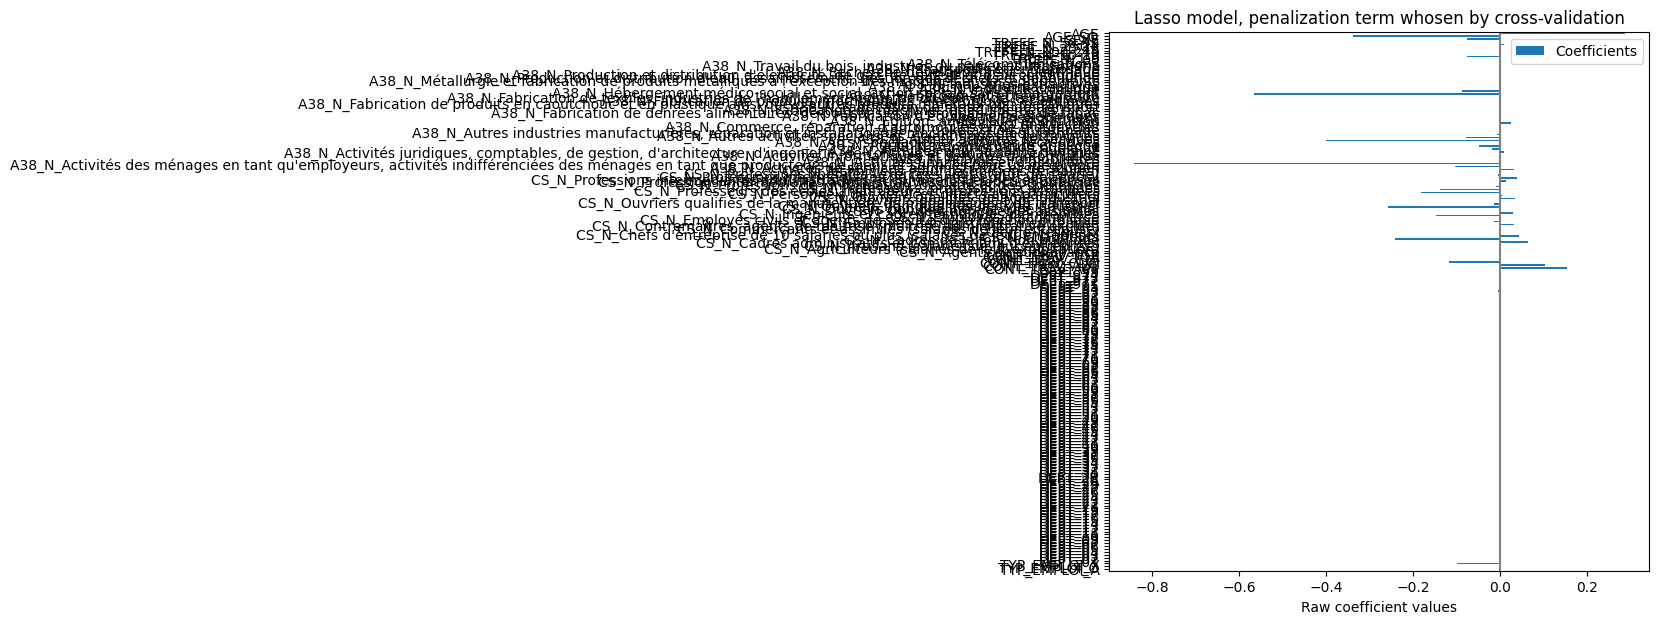

In [ ]:
# Display the value of selected coefficients
coefs.plot.barh(figsize=(9, 7))
plt.title("Lasso model, penalization term whosen by cross-validation")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

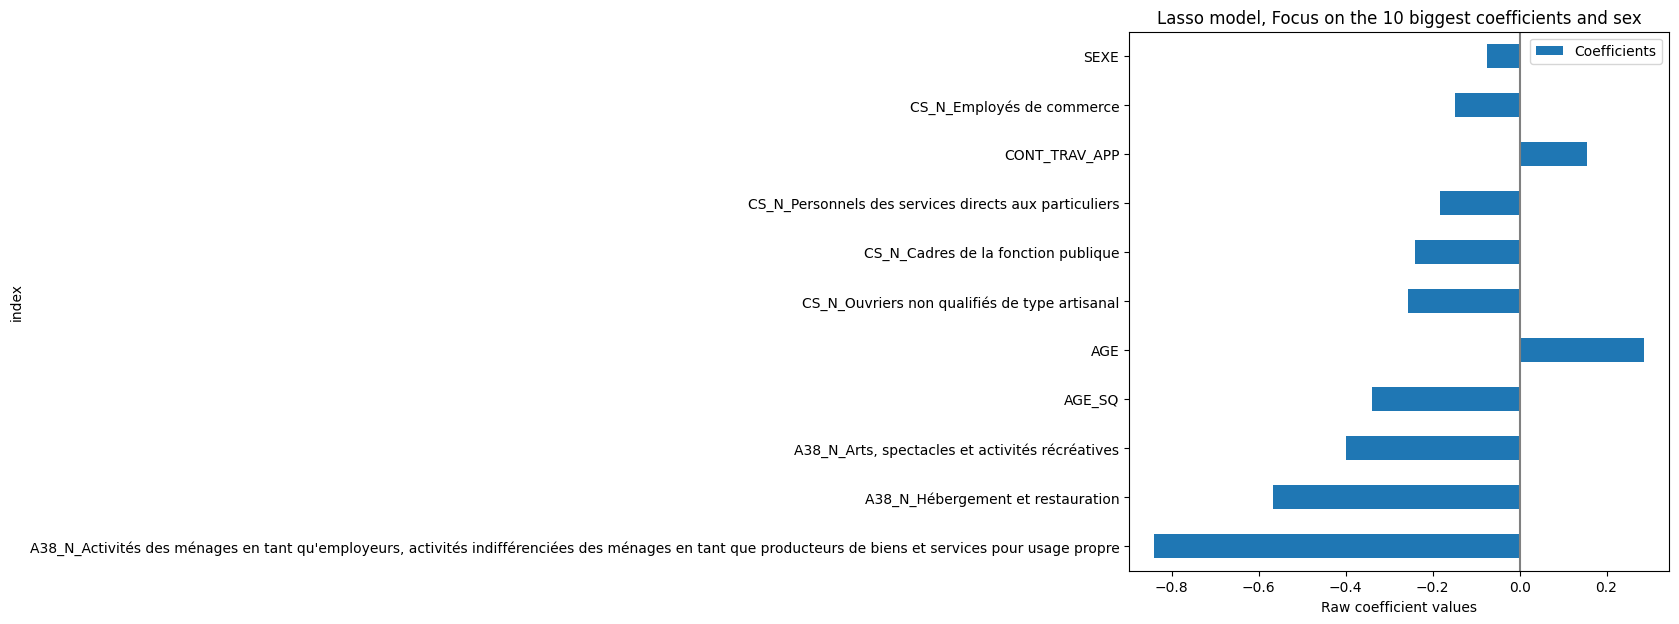

In [ ]:
# Showing all coefficients, beginning with the smaller ones
feature_names = model[:-1].get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs = coefs.reset_index()
coefs["abs_coefs"] = coefs["Coefficients"].abs()
large_coefs = coefs.sort_values("abs_coefs", ascending = False).head(10)
large_coefs = pd.concat([large_coefs, coefs[coefs["index"] == "SEXE"]])
large_coefs

# Display the value of selected coefficients
large_coefs.plot.barh(x='index', y='Coefficients', figsize=(9, 7))
plt.title("Lasso model, Focus on the 10 biggest coefficients and sex")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

As we can see, the LASSO procedure is quite efficient  in this framework in limiting the number of predictive variables considered. Here we end up selecting only 40 variables out of the almost 200 possible ones.

Interestingly for our question, the sex is among the selected ones, indicating that women work a fewer amount of time than men in this dataset. We also see that the age of the employee plays a significant role, which is highly non-linear. Many modalities of the socio-professional category, business sector as well as the type of contracts are selected by the model. The big absents are the départements, as only two of them are selected presently.

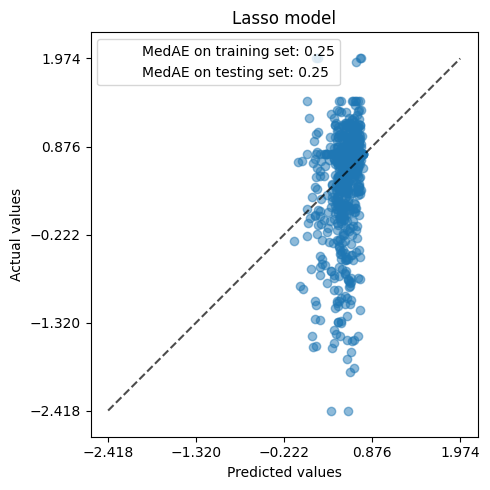

In [ ]:
#Computes the mean absolute error on the test sample
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
scores = {
    "MedAE on training set": f"{mae_train:.2f}",
    "MedAE on testing set": f"{mae_test:.2f}",
}


# Display the predicted value against the actual one, to test the quality of the model
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("Lasso model")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

To estimate the (standardized) number of hours worked, the LASSO procedure only selects a limited number of variables. As the graph above illustrates, it does not yield very precise estimates. This implies that the determinants of the number of hours worked are very complex, and seem to probably not be present in our dataset.

We restrict our attention to a more constrained question: variables affecting whethers employees work overtime.

## Linear probability model for the extra-hours

We begin in this section the analysis of whether employees work extra-hours or not. Our question is to understand whether the sex of the employee plays a role in determining whether the employee does extra hours or not, and if so by how much, once we have controlled for things such as the type of contract, the activity sector, the socio-professional category, the size of the firm and the age of the patient.

To do so, we simply focus on the subsample of employees in our data that have worked for the full duration of the year (360 days). The intuition behind is that the number of hours worked might be more reliable for this population, whho is less likely to resort to very short-tirm intensive types of contracts.

As our outcome variable is simply a dummy variable indicating whether the employee has worked more than 1820 hours, be estimate two models: a linear one and a logistic one. To see whether the sex of the employee is truely predictive, we compute LASSO regressions to select out the least predictive variables.

Accordingly, the regression analysis is the following:

$\mathbb{1}_{\text{Nb_Hours > 1820}} = \alpha_0 + \beta_1 \times \text{SPC} + \beta_2 \times \text{Type_job} + \beta_3 \times \text{Type_Contract} + \beta_4 \times \text{Activity Sector} + \beta_5 \times \text{Département} + \beta_6 \times \text{Business Sector} + \beta_7 \times \text{Age} + \beta_8 \times \text{Age}^2 + \beta_9 \times \text{Sex} + \epsilon$


The model is estimated by cross-validation on 80% of the data (training_set), trying 6 different values of the regularizing pparameter $\lambda$ : 0.0001, 0.001, 0.01, 0.1, 1, 10, and cross-validating 3 times within the training set for each of these lambda. We then extracts the coefficients selected with the optimal lambda determined above and interpret them. The quallity of the model relies on predictions done on the 20% of the observations that are kept aside for the testing (test_set)

In [ ]:
## This cell conducts cross-validation on the linear LASSO model, using standardized explanatory variables. None are selected in the end.


# Select relevant variables and keep only observations with all informatiosn
all_columns = ["TYP_EMPLOI", "DEPT", "CONT_TRAV", "CS_N", "A38_N", "TREFF_N", "SEXE", "AGE_SQ", "AGE"]
cleaned_base = base[base["DUREE"] == 360][all_columns + ["top_extra_hour_tot"]].dropna()
X = cleaned_base[all_columns]
y = cleaned_base['top_extra_hour_tot']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20250401)

# Selects and transforms the relevant variables
categorical_columns = ["TYP_EMPLOI", "DEPT", "CONT_TRAV", "CS_N", "A38_N", "TREFF_N"]
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
numerical_columns = ["SEXE", "AGE_SQ", "AGE"]

preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),

    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

# Do the lasso regressiion with a linear model
alphas = np.logspace(np.log10(0.0001), np.log10(10), num=6)  # alpha values to be chosen from by cross-validation
print(alphas)
start = time.time()
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=1000, n_jobs = -1, cv= 3)
    ),
)

_ = model.fit(X_train, y_train)
print(time.time() - start)

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
603.2256214618683


In [ ]:
# Get the optimal value of alpha as per the cross-validation stage
print("The optimal alpha is : ", model[-1].regressor_.alpha_)

# Showing all coefficients, beginning with the smaller ones
feature_names = model[:-1].get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs[coefs["Coefficients"] != 0 ].sort_values("Coefficients")

The optimal alpha is :  0.0001


,Coefficients
A38_N_Construction,-0.316538
A38_N_Hébergement et restauration,-0.241285
"A38_N_Arts, spectacles et activités récréatives",-0.175579
"A38_N_Activités des ménages en tant qu'employeurs, activités indifférenciées des ménages en tant que producteurs de biens et services pour usage propre",-0.152545
CS_N_Professions libérales (exercées sous statut de salarié),-0.149935
...,...
"CS_N_Contremaîtres, agents de maîtrise (maîtrise administrative exclue)",0.103589
CS_N_Ouvriers agricoles et assimilés,0.119289
CONT_TRAV_TTP,0.176993
CS_N_Agents de surveillance,0.192185


The penalty parameter selected by the model is the smallest tested, $1.0 e^{-4}$. This means that the constraint put on the model is not so efficient in selecting variables out, as the optimal model implies a small value of the regularization term so that it keeps for prediction purposes a large number of values. In this case, we keep more than half of the proposed variables, with many of them having a significant impact on the linear probability model of doing extra-hours. The larger coefficients are above 0.2 in absolute value, which is quite sizeable considerin the baseline share of employees doing extra hours of only 0.24.

As the optimal lambda selected is the minimum one, we should ideally test the model with smaller values of lambda, as the true optimal one could be inferior even to this value. However, trying to estimate the model with lower values of lambdas increases too much the computation time. Setting the max_iter parameter to 1000, the model takes 15 minutes to run for one of the three cross-validation made on the training set for one specific value of lambda and fails largely to converge, so that we gave up on that analysis. We would expect the optimal value of lambda to be lower, leading to a ven higher number of coefficients kept by the LASSO method.

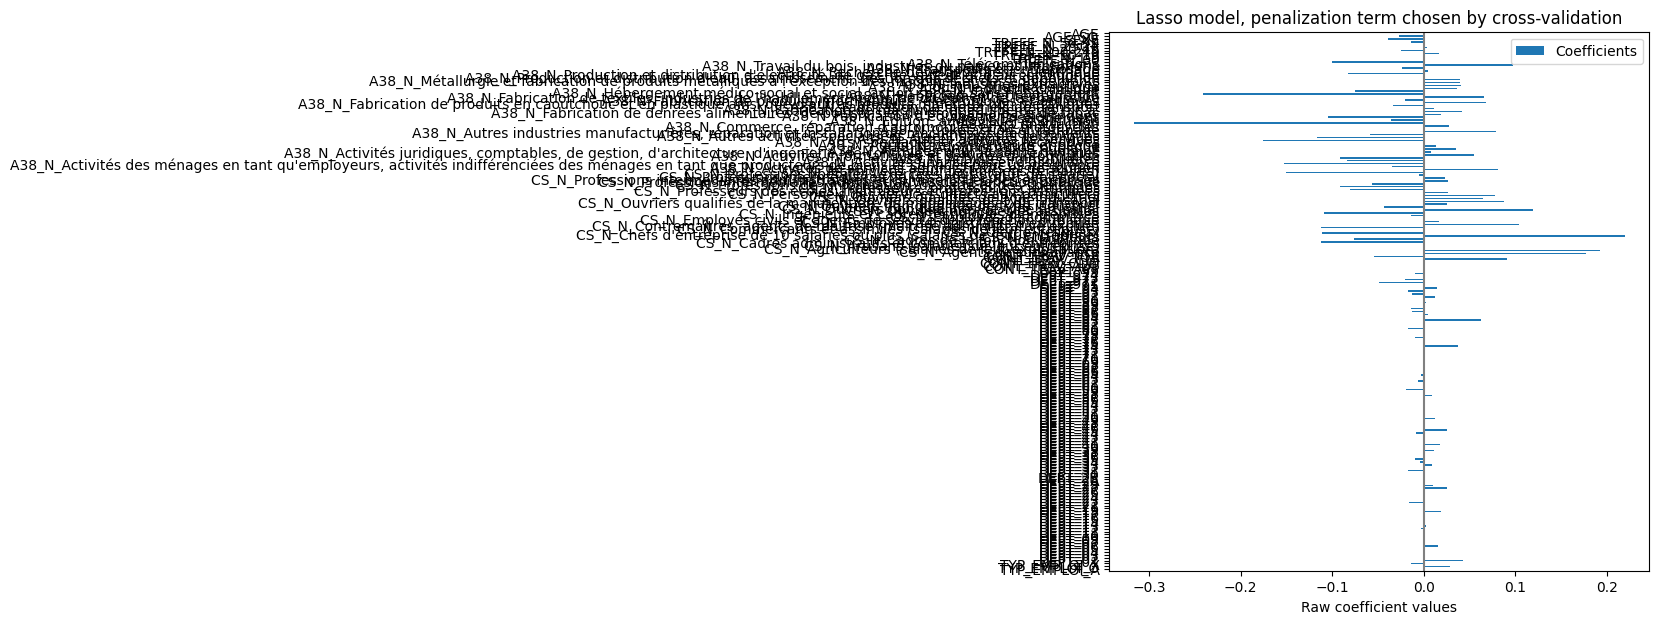

In [ ]:
# Display the value of selected coefficients
coefs.plot.barh(figsize=(9, 7))
plt.title("Lasso model, penalization term chosen by cross-validation")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Looking at the selected coefficients, we can see that the most significant ones are among the socioprofessionnal categories and the business sectors, who appear to be the most predictive variables as regards working extra-hours. The size of the firm, measued in number of employees, also plays a significant role, also the coefficients are smaller in magnitude. Most of the variables that are not selected are related to the geography (the départements), and those selected are of lower magnitude, so less relevant to predict the outcome.

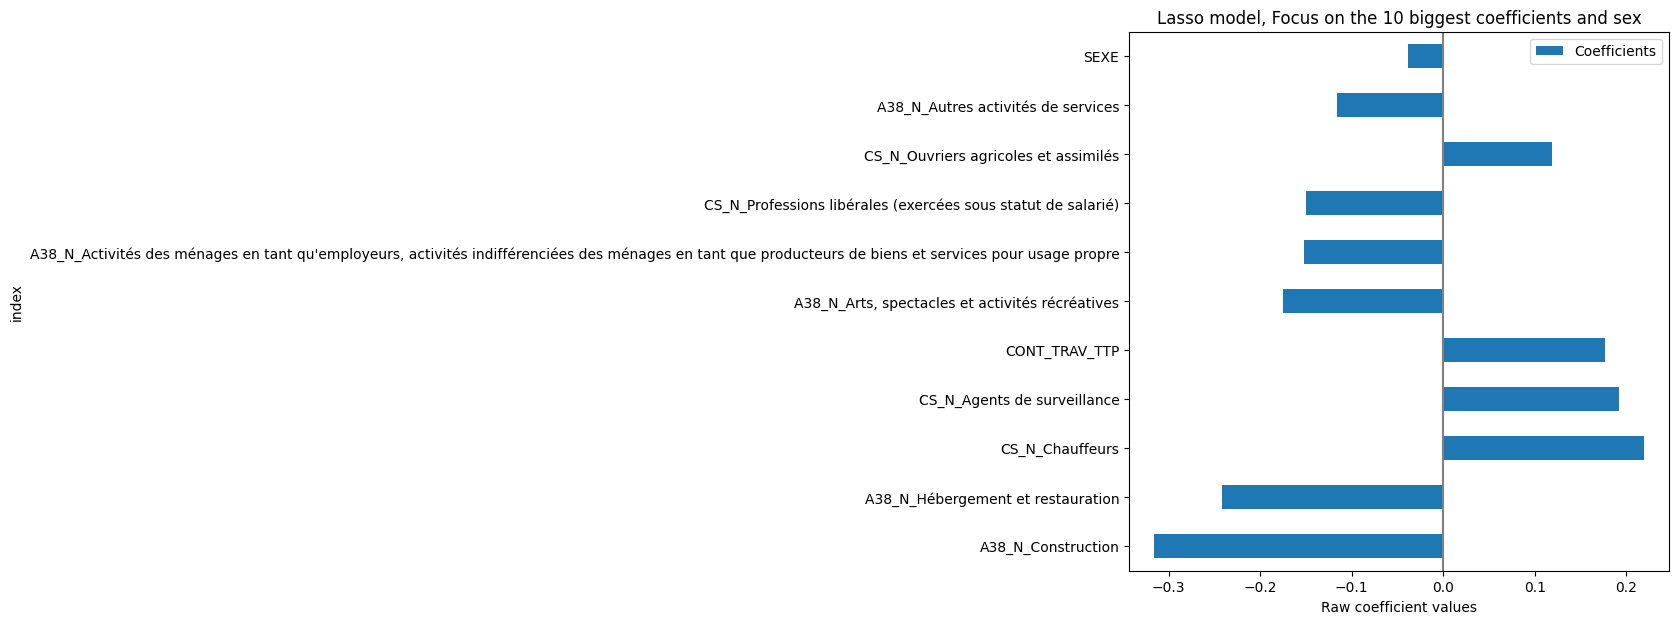

In [ ]:
# Showing all coefficients, beginning with the smaller ones
feature_names = model[:-1].get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]

coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)
coefs = coefs.reset_index()
coefs["abs_coefs"] = coefs["Coefficients"].abs()
large_coefs = coefs.sort_values("abs_coefs", ascending = False).head(10)
large_coefs = pd.concat([large_coefs, coefs[coefs["index"] == "SEXE"]])
large_coefs

# Display the value of selected coefficients
large_coefs.plot.barh(x='index', y='Coefficients', figsize=(9, 7))
plt.title("Lasso model, Focus on the 10 biggest coefficients and sex")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Consistently with what we observed above, we can see that the selected variables of higher magnitude are the ones related to the business sector and socio-professional category of the worker. In oppositiion, the sex of the worker is of a lower magnitude in explaining the propensity to work extra hours. However, that it remaines selected even after controlling for the socio-professional category and the business sector is a result in itself, as it implies that the sex of the worker as an impact on the result through other channels than just this one.

We discuss more extensively the results in the next section, on the logistic model.

In [ ]:
#Computes the mean absolute error on the test sample
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
print("MedAE on training set", f"{mae_train:.2f}")
print("MedAE on testing set", f"{mae_test:.2f}")

# Here we make the simplifying assumption that we predict 1 if the linear probability estimated is superior to 0.5, and compute the consfusion matrix
y_pred_binary = (y_pred > 0.5).astype(int)
pd.DataFrame(confusion_matrix(y_test, y_pred_binary))


MedAE on training set 0.26
MedAE on testing set 0.26


,0,1
0,267390,5118
1,78113,7589


Finally, the performance of the linear model in terms of predicting the outcome on the test set are poor. Though the accuracy is quite reasonnable (0.77) the precision is only decent (0.60) and the recall is very bad (0.09), all these indicators reflecting the imbalance of our outcom, which is far more frequently no extra hours than the opposite.

We try to improve it by using a logistic model.

## Logistic regressions with L1 penalization

In the previous sections, we trained linear models on the number of hours and on the dummy variable that employees conduct extra hours. In this section we try an alternative model for the binary variable, the logistic one, also including the L1 penalization. The idea is to test whether the same predictive variables are selected using both modelisation, comfirming their importance for the explanation of extra-hours worked;

Formally, the model we estimate in this section is the following:

$\hat{\beta} = \arg\min_{\beta} \left( - \sum_{i=1}^{n} \left[ y_i \log \left( \sigma(\mathbf{x}_i^\top \beta) \right) + (1 - y_i) \log \left( 1 - \sigma(\mathbf{x}_i^\top \beta) \right) \right] + \lambda \sum_{j=1}^{p} |\beta_j| \right)$

This is just a modification of the standard optimization problem of a logistic model ($\sigma(z) = \frac{1}{1 + e^{-z}}$ is the logistic function), with the first part of the sum designating the cross-entropy and the second part being the standard L1 penalization.

The model is estimated by cross-validation on 80% of the data (training_set), trying 6 different values of the regularizing pparameter $\lambda$ : 0.0001, 0.001, 0.01, 0.1, 1, 10, and cross-validating 3 times within the training set for each of these lambda. We then extracts the coefficients selected with the optimal lambda determined above and interpret them. The quallity of the model relies on predictions done on the 20% of the observations that are kept aside for the testing (test_set).

In [ ]:
## This cell conducts cross-validation on the logistic LASSO model, using standardized explanatory variables

# Select relevant variables and keep only observations with all informatiosn
all_columns = ["TYP_EMPLOI", "DEPT", "CONT_TRAV", "CS_N", "A38_N", "TREFF_N", "SEXE", "AGE_SQ", "AGE"]
cleaned_base = base[base["DUREE"] == 360][all_columns + ["top_extra_hour_tot"]].dropna()

X = cleaned_base[all_columns]
y = cleaned_base['top_extra_hour_tot']
y.value_counts()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20250401)

# Selects and transforms the relevant variables
categorical_columns = ["TYP_EMPLOI", "DEPT", "CONT_TRAV", "CS_N", "A38_N", "TREFF_N"]
for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
numerical_columns = ["SEXE", "AGE_SQ", "AGE"]

preprocessor = make_column_transformer(
    # For categorical columns: impute missing values with the most frequent value and apply OneHotEncoding
    (make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop="if_binary")), categorical_columns),

    # For numerical columns: impute missing values with the median and apply StandardScaler
    (make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numerical_columns)
)

# Conduct a lasso regressiion
alphas = np.logspace(np.log10(0.0001), np.log10(10), num=6)  # alpha values to be chosen from by cross-validation
print(alphas)
start = time.time()
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor= LogisticRegressionCV(Cs=alphas, penalty = "l1", solver = "liblinear",  max_iter=1000, n_jobs = -1, cv= 3)
    ),
)

_ = model.fit(X_train, y_train)
print(time.time() - start)
print("The optimal alpha is : ", model[-1].regressor_.C_)

[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]
2496.7095243930817
The optimal alpha is :  [0.1]


In [ ]:
# Showing all coefficients, beginning with the bigger ones
feature_names = model[:-1].get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]
coefs = pd.DataFrame(
    model[-1].regressor_.coef_[0],
    columns=["Coefficients"],
    index=feature_names,
)
coefs[coefs["Coefficients"] != 0].sort_values("Coefficients")

,Coefficients
A38_N_Construction,-2.742596
CONT_TRAV_TOA,-1.927513
CS_N_Professions libérales (exercées sous statut de salarié),-1.849042
A38_N_Hébergement et restauration,-1.848260
CS_N_Commerçants et assimilés (salariés de leur entreprise),-1.602540
...,...
A38_N_Industries extractives,0.516457
CONT_TRAV_TTP,0.580982
CS_N_Ouvriers agricoles et assimilés,0.745102
CS_N_Agents de surveillance,0.774166


As with the linear model, we see once again that we select a high number of variables: out of the 180 possible variables, 163 are selected in the end.

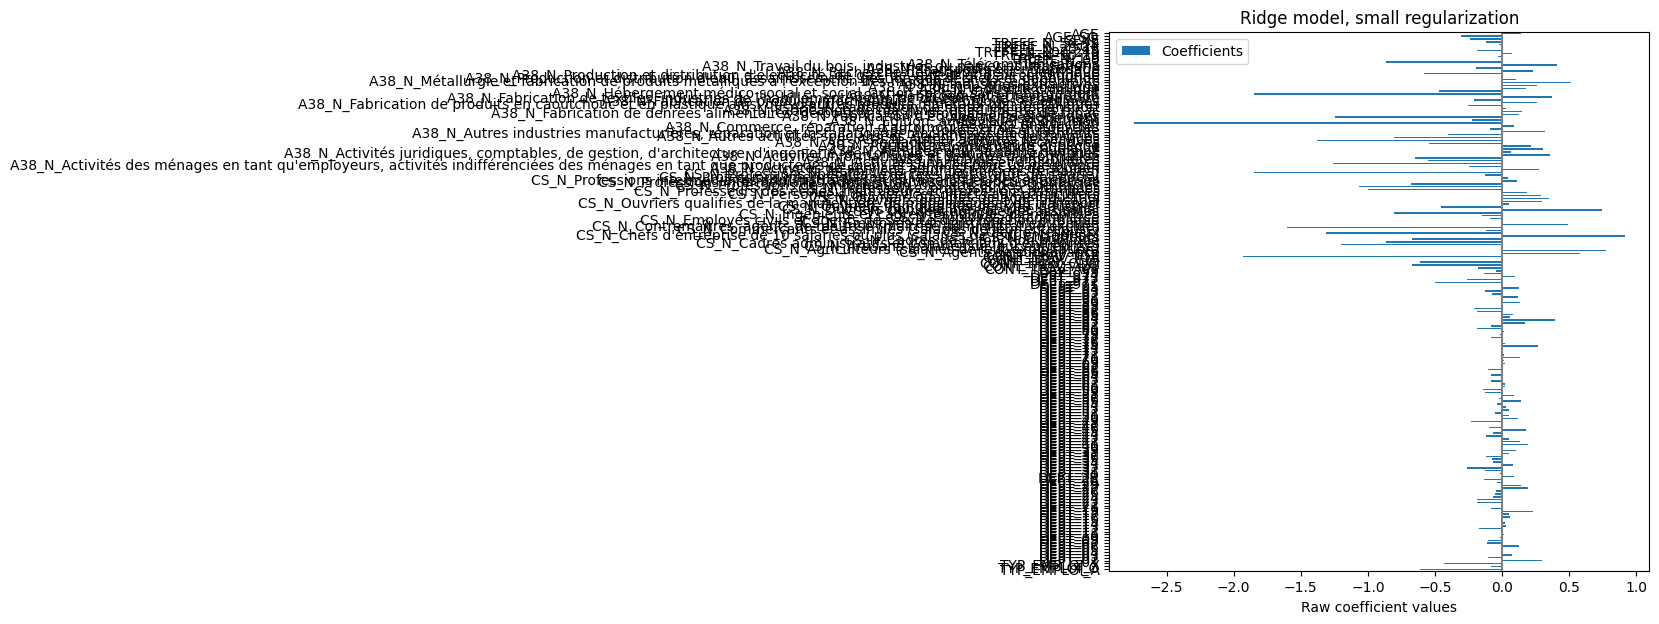

In [ ]:
coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge model, small regularization")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Even though the graph above is not completely readable, we can see that the most important coefficients (in terms of magnitude) selected are negative ones, indicating that our reference point is slightly high in terms of probability do do extra working hours. Comparing to the linear model, the ordering of coefficients selected in terms of their magnitude is largely the same, except for that slight left-lisding of coefficients associated to socio-professional categories and business sectors, probably due to a different reference point.

As with the linear model, both Sex, Age and Age squared are selected, suggesting the importance of these variables. That the Square of age is selected speaks to the non-linearity of the outcome variable as regards the age of the workers, which is an expected and standard type of result in the labour literature. Considering age in terms of complitely non-inear effects, with for instance specific effects for bins of 5-year groups, would probably be a very senseful alternative to the method we propose.

Moreover, we can see that the coefficients associated to PCS are very large related to the others, meaning that they are the most strongly predictive of working hours. Surprisingly, CSP+ tend to do less extra hours, with very large negative coefficients. We guess that it is an artifcat of the data generation process: these workers tend to heve specific contracts under which they do not have to report the number of hours worked, so that it us by default very often filled as 1820 hours a year. This does not mean that they actually work less than other workers.

The other large coefficients are those associated to business sectors, which exhibit quite large heterogeneities in terms of extra hours. Apprenticeship in particular is very negatively associated to extra hours, probably due to a more stringent regulation. The same goes for activity sectors, among whom some are very large.

We refrain from interpreting too much short-term contracts, as we are not looking at a set representative of these contracts.

Finally, départements are often selected as good predictors of the number of extra hours, even if the coefficients are not that large.

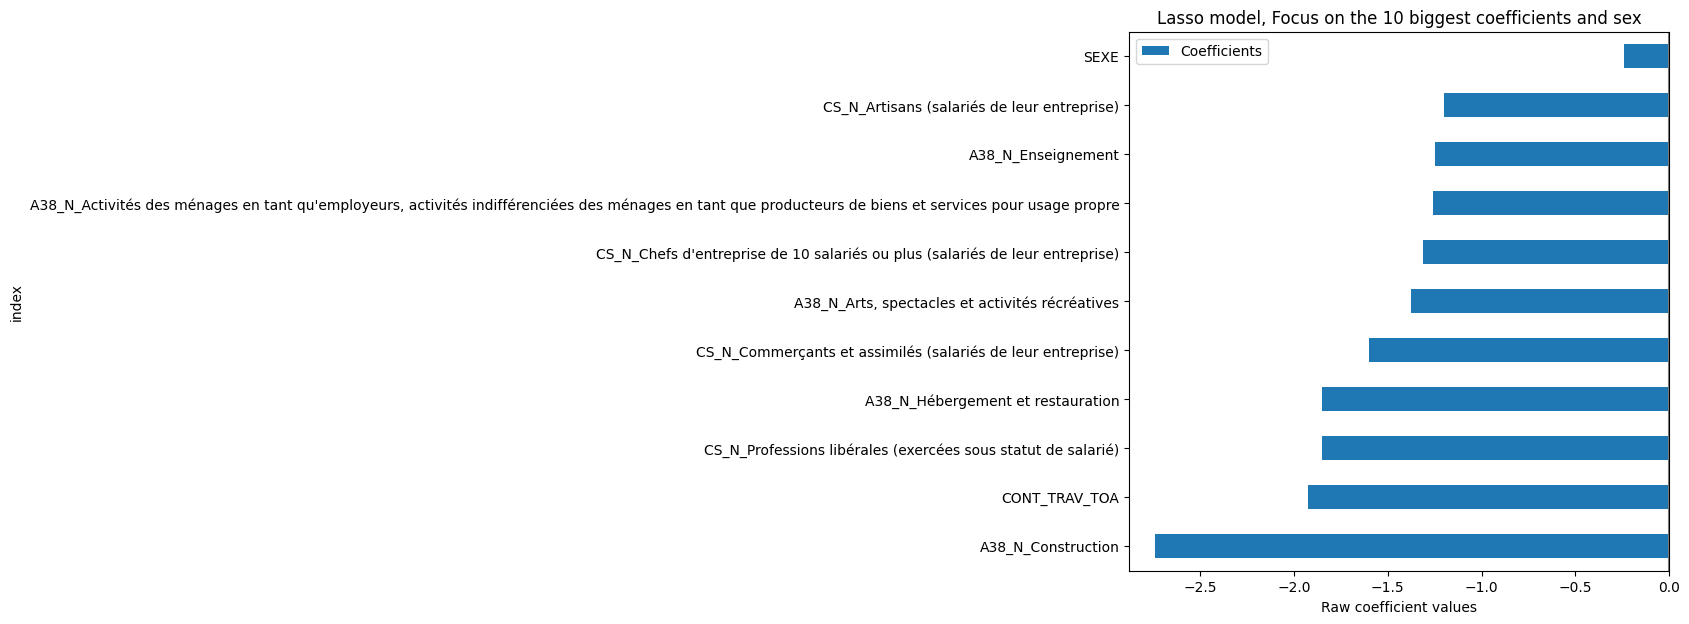

In [ ]:
# Showing all coefficients, beginning with the smaller ones
feature_names = model[:-1].get_feature_names_out()
feature_names = [name.split("__")[-1] for name in feature_names]

coefs = pd.DataFrame(
    model[-1].regressor_.coef_[0],
    columns=["Coefficients"],
    index=feature_names,
)
coefs = coefs.reset_index()
coefs["abs_coefs"] = coefs["Coefficients"].abs()
large_coefs = coefs.sort_values("abs_coefs", ascending = False).head(10)
large_coefs = pd.concat([large_coefs, coefs[coefs["index"] == "SEXE"]])
large_coefs

# Display the value of selected coefficients
large_coefs.plot.barh(x='index', y='Coefficients', figsize=(9, 7))
plt.title("Lasso model, Focus on the 10 biggest coefficients and sex")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

As we can see, representing the coefficient associated to sex next to the ten largesr coefficients, it appears to be relativey small. However, it remains a factor that predicts a lower propensity to do extra-hours, even controlling for factors such as profession, business sector, and types of contract, which are themselves influenced by the sex of the individual.

In [ ]:
#Computes the mean absolute error on the test sample
mae_train = median_absolute_error(y_train, model.predict(X_train))
y_pred = model.predict(X_test)
mae_test = median_absolute_error(y_test, y_pred)
print("MedAE on training set", f"{mae_train:.2f}")
print("MedAE on testing set", f"{mae_test:.2f}")

MedAE on training set 0.00
MedAE on testing set 0.00


Here we get a Median Absolute Error of 0. Howver, this is an expected result given the large imbalanceness of the classification variable: more than three quarters of our observations do not do extra-hours. Thus, we rightly predict in more than 50% of the cases that the workers do not do extra-hours, explaining this 0 median absolute error.

In [ ]:
# Build the confusion matrix
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
pd.DataFrame(confusion_matrix(df['y_test'], df['y_pred']))

,0,1
0,261470,11038
1,70921,14781


If we compare that model to the linear one, we almost double the number of True Positives. In that sense, our model is slightly better than the linear one. However, we still are very far from perfectly fitting the trues values: there are still 82% of the true values that we are not able to predict (False Negative), and we also doubled the number of False Positives.